In [8]:
import json
import numpy as np
from matplotlib import pyplot as plt
import urllib

from Chandra.Time import DateTime
import Ska.engarchive.fetch_eng as fetch_eng
import xija

%matplotlib inline

Define function to calculate DPA temperatures

In [2]:
def dpa_prod(tstart, tstop):    
    model_spec_url = 'https://raw.githubusercontent.com/sot/chandra_models/master/chandra_models/xija/dpa/dpa_spec.json'
    response = urllib.urlopen(model_spec_url);
    model_spec = json.loads(response.read())
    
    model = xija.ThermalModel('dpa', start=tstart, stop=tstop, model_spec=model_spec)

    model.make()
    model.calc()
    msiddata = model.get_comp('1dpamzt')
    return msiddata

Calculate modeled DPA temperatures

In [3]:
tstart = DateTime('2015:340:00:00:00').secs
tstop = tstart + 3600*24*182
msiddata = dpa_prod(tstart, tstop)

Fetching msid: 1dpamzt over 2015:339:23:34:08.816 to 2016:157:00:20:48.816
Fetching msid: sim_z over 2015:339:23:34:08.816 to 2016:157:00:20:48.816
Fetching msid: pitch over 2015:339:23:34:08.816 to 2016:157:00:20:48.816
Fetching msid: roll over 2015:339:23:34:08.816 to 2016:157:00:20:48.816
Fetching msid: aoeclips over 2015:339:23:34:08.816 to 2016:157:00:20:48.816
Reading commanded states DB over 2015:340:00:01:28.816 to 2016:156:23:53:28.816
Fetching msid: dp_dpa_power over 2015:339:23:34:08.816 to 2016:157:00:20:48.816


Query SIM position and radmon status

In [4]:
data = fetch_eng.Msidset(['3tscpos', 'coradmen'], tstart, tstop, stat=None)
dtvals, dtcounts = np.unique(np.diff(data['coradmen'].times), return_counts=True)
dtcommon = dtvals[np.argmax(dtcounts)]
data.interpolate(dt=dtcommon)

Filter out non-ACIS observations and durations when radmon is enabled (crude way to remove HRC and CTI observations)

In [5]:
ind = (data['3tscpos'].vals >= 70736) & (data['coradmen'].vals == 'ENAB')
modeldata = np.interp(data.times[ind], msiddata.times, msiddata.mvals)
telemdata = np.interp(data.times[ind], msiddata.times, msiddata.dvals)

Show indices of observations with error greater than 2C associated with telemetry values greater than 35.5C

In [6]:
large_hot_error_indices = np.where(((telemdata - modeldata) > 2.) & (telemdata > 35.5))
print(large_hot_error_indices)

(array([], dtype=int64),)


As can be seen above, there are no ACIS observations outside of the radzone associated with DPA temperatures greater than 35.5C and model errors greater than 2.0C 

Plot model and telemetry data

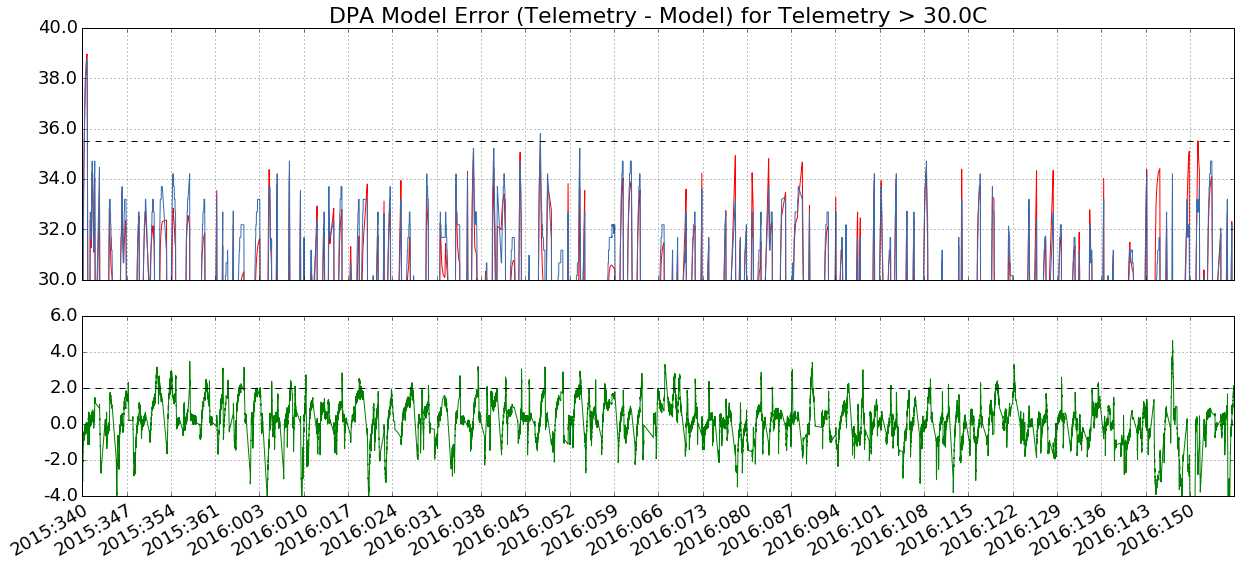

In [7]:
# minorLocator   = AutoMinorLocator(1)
xdate = np.arange(DateTime(tstart).secs, DateTime(tstop).secs, 3600*24*7)
xtik = DateTime(xdate).secs
xlab = np.array([t[:8] for t in DateTime(xdate).date])
telemblue = '#386cb0'
    
fig = plt.figure(figsize=(20,10),facecolor=[1,1,1])
ax1 = fig.add_axes([0.1, 0.50, 0.8, 0.35])
ax1.hold(True)
ax1.plot(data.times[ind], modeldata, color='r')
ax1.plot(data.times[ind], telemdata, color=telemblue)
ax1.plot(ax1.get_xlim(), [35.5, 35.5], color='black', linestyle='--')
ax1.grid(True)
ax1.set_ylim(30, 40)
_ = ax1.set_xticks(xtik)
_ = ax1.set_xticklabels('')
_ = ax1.set_xlim(data.times[0], data.times[-1])
_ = ax1.set_yticklabels(ax1.get_yticks(), fontsize=18)

ax2 = fig.add_axes([0.1, 0.2, 0.8, 0.25])
ax2.hold(True)
ax2.plot(data.times[ind], telemdata-modeldata, color='g')
ax2.plot(ax2.get_xlim(), [2.0, 2.0], color='black', linestyle='--')
ax2.grid(True)
ax2.set_ylim(-4, 6)
ax2.set_xlim(data.times[0], data.times[-1])
_ = ax2.set_xticks(xtik)
_ = ax2.set_xticklabels(xlab, fontsize=18, rotation=30, rotation_mode='anchor', ha='right')
_ = ax2.set_yticklabels(ax2.get_yticks(), fontsize=18)

ax1.set_title('DPA Model Error (Telemetry - Model) for Telemetry > 30.0C', fontsize=22)